# Optyx: A ZX-based Python library for networked quantum architectures

## Building blocks

 ![generators](./generators.png "Optyx Generators")

### Photonic generators and syntax

 ![photonic_generators](./photonic_generators.png "Photonic Generators")

In [1]:
from optyx.photonic import BBS

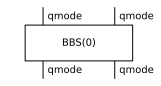

In [2]:
beam_splitter = BBS(0)
beam_splitter.draw()

In [3]:
from optyx.photonic import Create

In [4]:
hong_ou_mandel = (
    Create(1) @ Create(1) >>
    beam_splitter
)

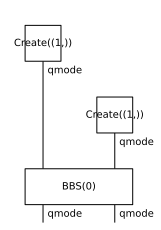

In [5]:
hong_ou_mandel.draw()

 ![HOM](./hom.png "Hong-Ou-Mandel Effect")

In [6]:
# evaluation => the semantics of the diagram
hong_ou_mandel.eval().prob_dist()

{(0, 2): 0.5, (1, 1): 4.9303806576313227e-32, (2, 0): 0.5}

In [7]:
from optyx.classical import Select
(hong_ou_mandel >> Select(1, 1)).eval().tensor.array

array(-0.+0.j)

### Qubit and classical generators

 ![qubit_generators](./qubit_generators.png "Qubit Generators")

In [8]:
# ZX-calculus
from optyx.qubits import Ket, Z, X, H

In [9]:
diagram = Ket(1) >> X(1, 1, 0.5) >> H() >> Z(1, 1, 0.5)

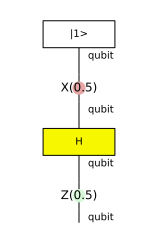

In [10]:
diagram.draw(figsize=(2, 3))

In [11]:
diagram.eval().amplitudes()

{(0,): (0.7071067811865476+0j),
 (1,): (-0.7071067811865476+2.5978681687064796e-16j)}

 ![classical_generators](./classical_generators.png "Classical Generators")

In [12]:
# measurement
from optyx.qubits import Measure

In [13]:
measured_diagram = diagram >> Measure(1)

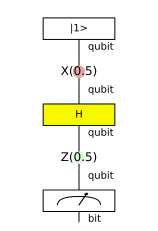

In [14]:
measured_diagram.draw(figsize=(2, 3))

In [15]:
measured_diagram.eval().amplitudes()

TypeError: Cannot get amplitudes from density matrix or probability distribution.

In [16]:
measured_diagram.eval().prob_dist()

{(0,): (0.5+0j), (1,): (0.5+0j)}

In [17]:
from optyx.classical import AndBit

circuit = (
    measured_diagram @ measured_diagram >>
    AndBit()
)

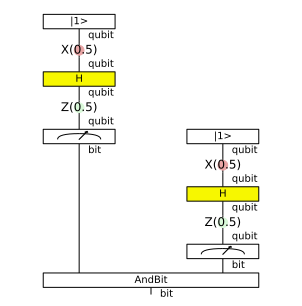

In [18]:
circuit.foliation().draw(figsize=(4, 4))

In [19]:
circuit.eval().prob_dist()

{(0,): (0.7500000000000001-2.0526832973508108e-48j),
 (1,): (0.25+2.0526832973508108e-48j)}

### Qubit teleportation - function syntax and backends

<img src="teleport.svg" alt="Teleportation Protocol" width="800" style="max-width:100%;">


In [20]:
from optyx.classical import (
  BitControlledGate
)
from optyx import qubit, bit

In [21]:
teleportation = (
    Z(1, 2) @ Z(0, 2) >>
    qubit @ X(2, 1) @ qubit >>
    H() @ qubit @ qubit >>
    Measure(1) @ Measure(1) @ qubit >>
    bit @ BitControlledGate(
                X(1, 1, 0.5)
    ) >>
    BitControlledGate(
        Z(1, 1, 0.5)
    )
)

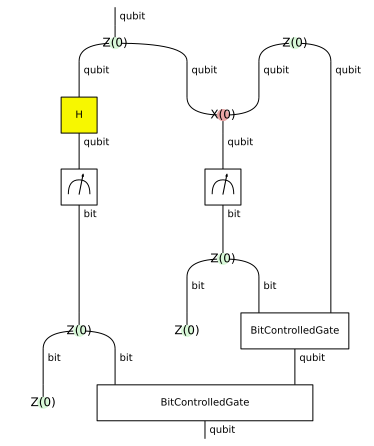

In [22]:
teleportation.foliation().draw()

In [23]:
teleportation.eval().prob_dist()

ValueError: Result tensor must represent a state with inputs.

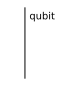

In [24]:
from optyx.qubits import Id

Id(1).draw()

In [25]:
import numpy as np

np.allclose(
    teleportation.eval().tensor.array,
    Id(1).double().to_tensor().eval().array
)

True

In [26]:
from optyx import Diagram

@Diagram.from_callable(
  dom=qubit, cod=qubit
)
def teleportation(a):
  b = (
    Z(1, 2) @ Z(0, 2)
  )(a)

  d = X(2, 1)(b[1], b[2])

  e = (
    Measure(1) @ Measure(1)
  )(H()(b[0]), d)

  f = BitControlledGate(
    X(1, 1, 0.5)
  )(e[1], b[3])

  return BitControlledGate(
    Z(1, 1, 0.5)
  )(e[0], f)

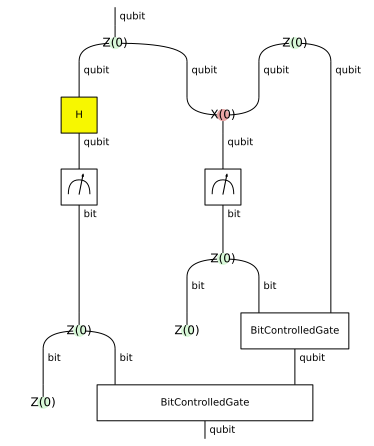

In [27]:
teleportation.foliation().draw()

In [28]:
from optyx.core.backends import (
    DiscopyBackend,
    QuimbBackend
)

In [29]:
teleportation.eval(DiscopyBackend()).tensor.array

array([[[[ 1.+0.j, -0.+0.j],
         [-0.+0.j,  0.+0.j]],

        [[ 0.+0.j,  1.+0.j],
         [ 0.-0.j,  0.+0.j]]],


       [[[ 0.+0.j,  0.+0.j],
         [ 1.-0.j, -0.+0.j]],

        [[ 0.+0.j,  0.+0.j],
         [ 0.+0.j,  1.+0.j]]]])

In [30]:
from cotengra import HyperCompressedOptimizer
optimiser = HyperCompressedOptimizer(
    chi=1
)

In [31]:
teleportation.eval(QuimbBackend(optimiser)).tensor.array

/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:329: UserWarning: Trial error: not enough values to unpack (expected 2, got 1). Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:329: UserWarning: Trial error: not enough values to unpack (expected 2, got 1). Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/cotengra/hyperoptimizers/hyper.py:329: UserWarning: Trial error: not enough values to unpack (expected 2, got 1). Set `HyperOptimizer` kwarg `on_trial_error='raise'` to raise this error, or `on_trial_error='ignore'` to silence.
  warnings.warn(
/home/mateuszkupper/Documents/optyx/.venv/lib/python

array([[[[0.06248093+0.j, 0.06248093-0.j],
         [0.06248093+0.j, 0.06248093+0.j]],

        [[0.06248093+0.j, 0.06248093-0.j],
         [0.06248093+0.j, 0.06248093+0.j]]],


       [[[0.06248093+0.j, 0.06248093-0.j],
         [0.06248093+0.j, 0.06248093+0.j]],

        [[0.06248093+0.j, 0.06248093-0.j],
         [0.06248093+0.j, 0.06248093+0.j]]]])

In [32]:
optimiser = HyperCompressedOptimizer(
    chi=2
)

In [33]:
teleportation.eval(QuimbBackend(optimiser)).tensor.array

array([[[[1.-0.j, 0.-0.j],
         [0.+0.j, 0.-0.j]],

        [[0.+0.j, 1.+0.j],
         [0.+0.j, 0.+0.j]]],


       [[[0.-0.j, 0.-0.j],
         [1.-0.j, 0.-0.j]],

        [[0.+0.j, 0.+0.j],
         [0.-0.j, 1.-0.j]]]])

## Interfacing with external libraries

### Graphix graphs

In [34]:
import graphix
from optyx import qubits

circuit = graphix.Circuit(2)
circuit.rz(0, 0.5)
circuit.rz(1, 0.5)
circuit.cnot(0, 1)
circuit.s(0)
circuit.cnot(1, 0)

pattern = circuit.transpile().pattern

# open graph zx diagram
optyx_zx = qubits.Circuit(pattern)

The pattern is not consistent with flow or gflow structure.


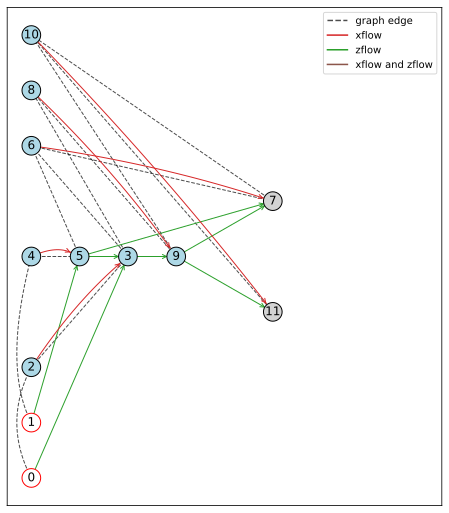

In [35]:
pattern.draw_graph()

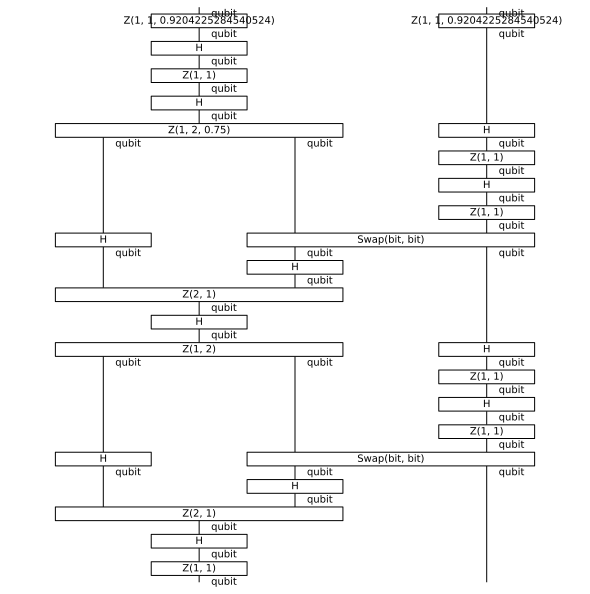

In [36]:
optyx_zx.foliation().draw(figsize=(8, 8))

### Perceval circuits and processors

In [37]:
import perceval as pcvl
from optyx import Channel

In [38]:
p = pcvl.Processor("SLOS", 6)
p.add(0, pcvl.catalog["postprocessed cnot"].build_processor())

p.add(0, pcvl.BS.H())
p.add(0, pcvl.Detector.pnr())
p.add(1, pcvl.Detector.pnr())
p.add(2, pcvl.Detector.pnr())
p.add(3, pcvl.Detector.pnr())

ff_X = pcvl.FFCircuitProvider(
  2, 0, pcvl.Circuit(2)
)
ff_X.add_configuration(
  [0, 1], pcvl.PERM([1, 0])
)
p.add(2, ff_X)

phi = pcvl.P("phi")
ff_Z = pcvl.FFConfigurator(
  2, 3,
  pcvl.PS(phi),
  {"phi": 0}
).add_configuration(
  [0, 1],
  {"phi": np.pi}
)
p.add(0, ff_Z)

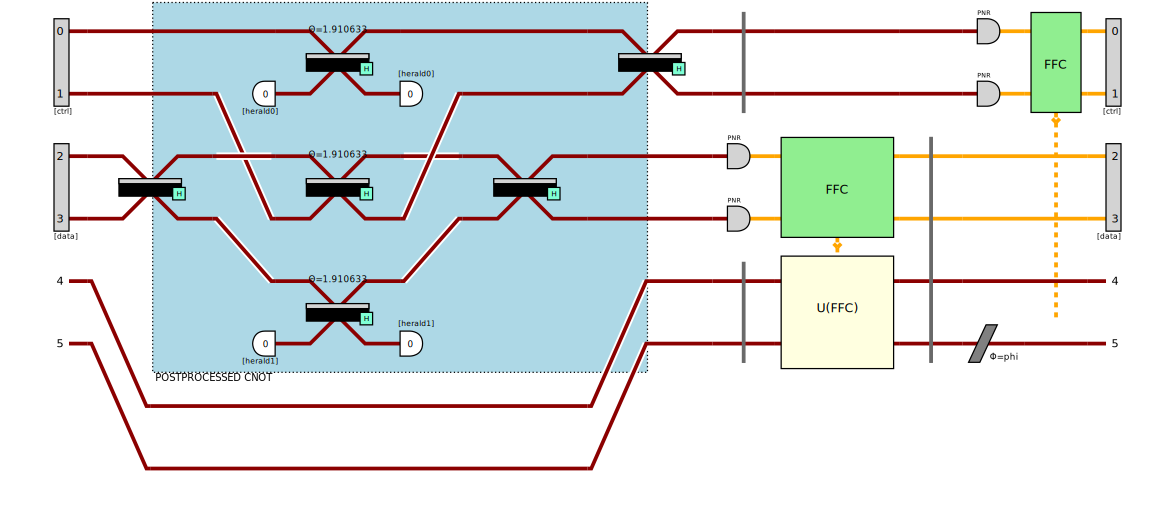

In [39]:
pcvl.pdisplay(p, recursive=True)

In [40]:
# convert to Optyx
optyx_diagram = Channel.from_perceval(p)

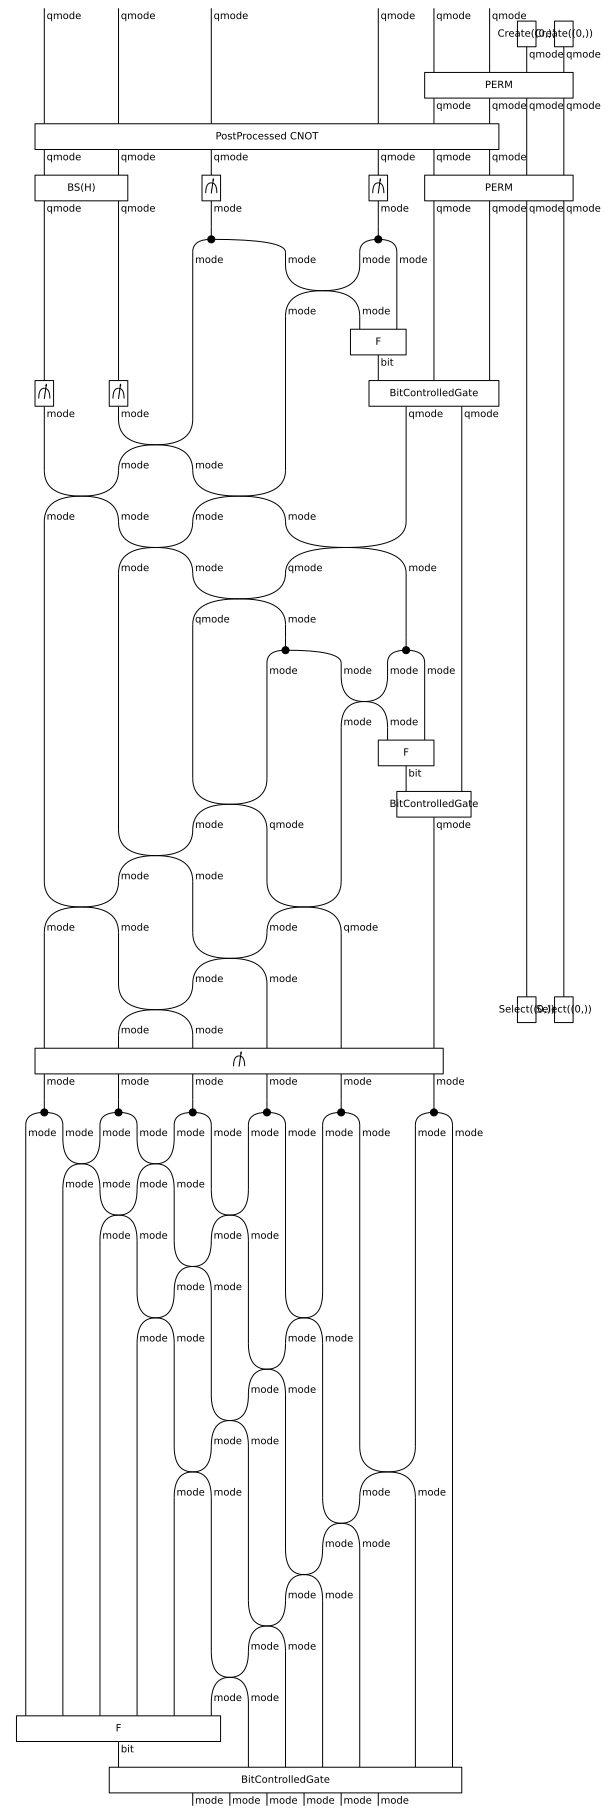

In [42]:
optyx_diagram.foliation().draw(figsize=(8, 25))

In [43]:
to_transmit = ((0.7071067811865476+0j)*pcvl.BasicState([1, 0]) +
               (-0.21850801222441052+0.6724985119639574j)*pcvl.BasicState([0, 1]))
to_transmit.normalize()

sg = pcvl.StateGenerator(pcvl.Encoding.DUAL_RAIL)
bell_state = sg.bell_state("phi+")

input_state = to_transmit * bell_state
p.min_detected_photons_filter(2)

input_state *= pcvl.BasicState([0, 0])

p.with_input(input_state)

In [44]:
result_perceval = p.probs()

In [45]:
from optyx.qubits import Scalar
from optyx.photonic import DualRail

bell_state = Z(0, 2) @ Scalar(0.5**0.5)
transmit = Ket("+") >> Z(1, 1, 0.3)

protocol = (
    transmit @ bell_state >>
    DualRail(3) >>
    Channel.from_perceval(p)
)

In [46]:
result_optyx = protocol.eval().prob_dist()

In [47]:
def check_dict_agreement(d1, d2, rtol=1e-5, atol=1e-8):
    for key in d1.keys() - d2.keys():
        assert np.isclose(d1[key], 0, rtol=rtol, atol=atol)
    for key in d2.keys() - d1.keys():
        assert np.isclose(d2[key], 0, rtol=rtol, atol=atol)
    for key in d1.keys() & d2.keys():
        assert np.isclose(d1[key], d2[key], rtol=rtol, atol=atol)

In [48]:
check_dict_agreement(
    {tuple(k): v for k, v in dict(result_perceval["results"]).items()},
    result_optyx
)

## Fusion teleportation

Graphically, the fusion measurement we would like to use, takes the following form:

![Fusion II](./fusion_ii.png "Fusion measurement implementing a Bell measurement in dual rail encoding")


where $\underline{a}, \underline{b}, \underline{c}, \underline{d}$ are the measurement outcomes as the measured photon numbers. 

In [49]:
from optyx import qmode

from optyx.photonic import (
    DualRail,
    Swap,
    HadamardBS
)

fusion = (
    HadamardBS() @ HadamardBS() >>
    qmode @ Swap(1, 1) @ qmode >>
    qmode @ HadamardBS() @ qmode >>
    Swap(1, 1) @ qmode @ qmode >>
    qmode @ Swap(1, 1) @ qmode >>
    qmode @ qmode @ HadamardBS()
)

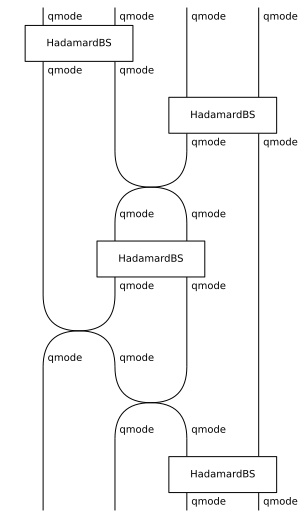

In [50]:
fusion.draw()

As we are dealing with dual-rail encoding, we will restrict ourselves to the outcome results where the total measured number of photons is 4. We have that $\underline{s} = \underline{a} \oplus \underline{b}$ is the Boolean value of success (whether an entangling operation succeeded) and $\underline{k} = \underline{s} (\underline{b} + \underline{d}) + \neg \underline s (1 - \frac{\underline{a} + \underline{b}}{2})$ is the Pauli error.
This means that the error is $\underline{b} + \underline{d}$ in case of success and $1 - \frac{\underline{a} + \underline{b}}{2}$ in case of failure.

We interpret this diagram as a CP-map which means that the sums represent classical mixing and not quantum superposition. We obtain different protocols conditioned on the value of $\underline{s}$ and $\underline{k}$.

In our analysis we will ignore the case when the fusion fails.

In [51]:
from optyx.classical import (
    ClassicalFunction
)

from optyx import mode, bit

def fusion_function(x):
    """
    A classical function that returns two bits based on an input x,
    based on the classical logical for the Fusion type II circuit.
    """
    a = x[0]
    b = x[1]
    c = x[2]
    d = x[3]
    s = (a % 2) ^ (b % 2)
    k = int(s*(b + d) + (1-s)*(1 - (a + b)/2))%2
    return [s, k]

classical_function = ClassicalFunction(
    fusion_function,
    mode**4,
    bit**2
)

In [52]:
from optyx.classical import PostselectBit

fusion_failure_processing = PostselectBit(1)

In [53]:
from optyx.photonic import Phase
from optyx.classical import BitControlledGate

# apply the box if the control bit is 1, otherwise apply an identity channel
correction = BitControlledGate(
    HadamardBS() >>
    (Phase(0.5) @ qmode) >>
    HadamardBS()
)

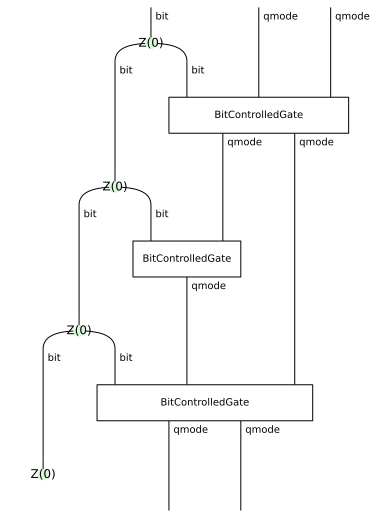

In [54]:
correction.draw()

In [55]:
from optyx.qubits import Z
from optyx.photonic import Scalar

channel_bell = (
    Z(0, 2) @ Scalar(0.5**0.5) >> DualRail(1) @ DualRail(1)
)

dual_rail_input = DualRail(1)

In [56]:
from optyx.photonic import NumberResolvingMeasurement

teleportation = (
    dual_rail_input @ channel_bell >>
    fusion @ qmode**2 >>
    NumberResolvingMeasurement(4) @ qmode**2 >>
    classical_function @ qmode**2 >>
    fusion_failure_processing @ correction >>
    DualRail(1).dagger()
)

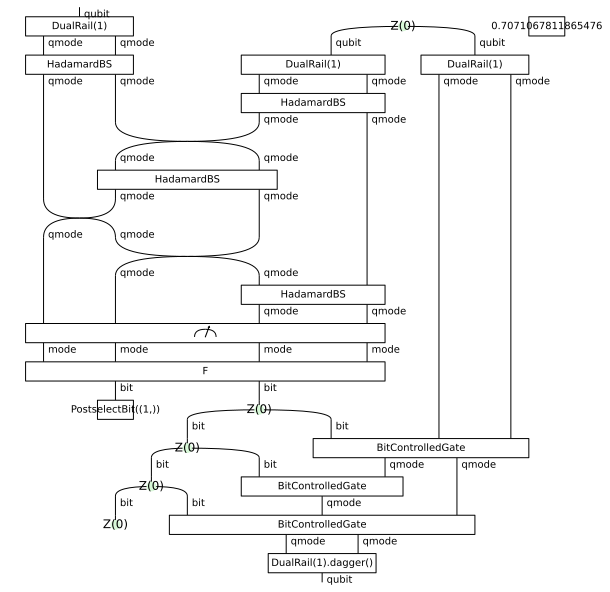

In [58]:
teleportation.foliation().draw(figsize=(8, 8))

In [59]:
array_teleportation = teleportation.eval().tensor.array

In [60]:
from optyx.photonic import Id

array_id = (
    Id(1) @ Scalar(0.5**0.5)
).double().to_tensor().eval().array

In [61]:
import numpy as np

np.allclose(array_teleportation, array_id)

True

### Fusion with distinguishable photons

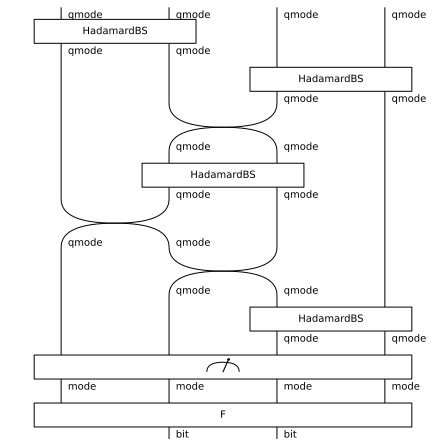

In [62]:
fusion_channel = fusion >> NumberResolvingMeasurement(4) >> classical_function
fusion_channel.draw(figsize=(6, 6))

In [ ]:
internal_state_1 = [1, 0]
internal_state_2 = [0, 1]
internal_state_2 = internal_state_2 / np.linalg.norm(internal_state_2)

print(internal_state_1, internal_state_2)

[1, 0] [0. 1.]


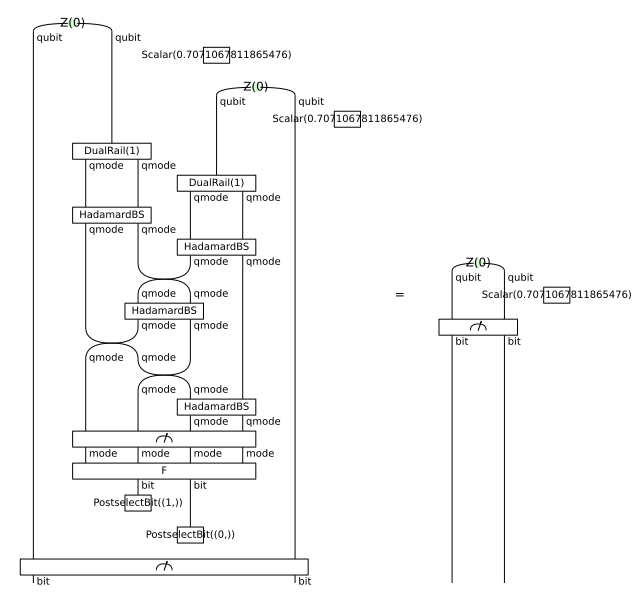

In [70]:
from optyx.qubits import Z, Scalar, Id, Measure
from optyx.photonic import DualRail
from optyx.classical import PostselectBit
from discopy.drawing import Equation

bell_state = Z(0, 2) @ Scalar(0.5 ** 0.5)
dual_rail_encoding = lambda state: DualRail(1, internal_states=[state])
encoding_layer =  dual_rail_encoding(internal_state_1) @ dual_rail_encoding(internal_state_2)
post_select = PostselectBit(1) @ PostselectBit(0)
experiment = bell_state @ bell_state >> Id(1) @ (encoding_layer >> fusion_channel >> post_select) @ Id(1)
measure = Measure(2)
Equation(experiment >> measure, bell_state >> measure).draw(figsize=(8, 8))

In [75]:
from optyx.qubits import Discard

In [76]:
fidelity = (experiment >> bell_state.dagger())

In [77]:
normalisation = (experiment >> Discard(2)).inflate(2).eval().tensor.array

In [78]:
f = fidelity.inflate(2).eval().tensor.array
f/normalisation

(0.5000000000000001-3.061616997868383e-17j)

In [79]:
import math

def rotated_unit_vectors(n: int = 10):
    for i in range(n):
        theta = i * (math.pi / 2) / (n - 1)
        yield (math.cos(theta), math.sin(theta))

In [80]:
unit_vectors = list(rotated_unit_vectors(30))

In [81]:
inner_product_states = []
inner_product_bell_states = []

result_bell = bell_state.eval().tensor.array.flatten()
result_bell = result_bell / np.linalg.norm(result_bell)

for vector in unit_vectors:
    encoding_layer =  dual_rail_encoding(internal_state_1) @ dual_rail_encoding(vector)
    experiment = bell_state @ bell_state >> Id(1) @ (encoding_layer >> fusion_channel
                                                                                >> post_select) @ Id(1)

    f = (experiment >> bell_state.dagger()).inflate(2).eval().tensor.array
    normalisation = (experiment >> Discard(2)).inflate(2).eval().tensor.array

    inner_product_states.append(np.inner(vector, internal_state_1))
    inner_product_bell_states.append(f/normalisation)

/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mateuszkupper/Documents/optyx/.venv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


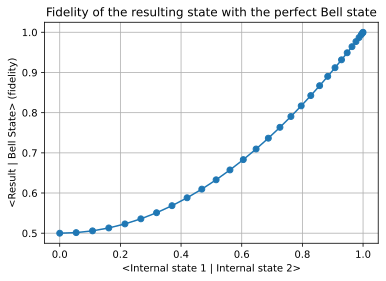

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(inner_product_states, inner_product_bell_states, marker='o')
plt.xlabel('<Internal state 1 | Internal state 2>')
plt.ylabel('<Result | Bell State> (fidelity)')
plt.title('Fidelity of the resulting state with the perfect Bell state')
plt.grid(True)
plt.show()

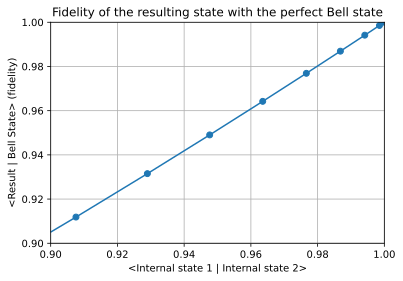

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(inner_product_states, inner_product_bell_states, marker='o')
plt.xlabel('<Internal state 1 | Internal state 2>')
plt.ylabel('<Result | Bell State> (fidelity)')
plt.title('Fidelity of the resulting state with the perfect Bell state')
plt.xlim(0.9, 1)
plt.ylim(0.9, 1)
plt.grid(True)
plt.show()